In [2]:
import dateutil.parser
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import torch.nn.functional as F
from pathlib import Path
import seaborn as sns
import sys

In [3]:

class seq2seq(nn.Module):

    def __init__(self, hid_dim, in_chan, layers, output_dim, dropout, device):
        super(seq2seq, self).__init__()

        self.hid_size = hid_dim
        self.device = device
        self.dropout = nn.Dropout(dropout)
        
        """ ARCHITECTURE 
        # input （batch, seq_len, input_size）
        # output (batch, seq_len, num_directions * hidden_size）
        # Encoder (LSTM)
        # Encoder Vector (final hidden state of encoder)
        # Decoder (LSTM) - takes Encoder Vector as input
        """

        self.encoder_lstm = nn.LSTM(in_chan+27, hid_dim, layers,
                                    dropout=dropout,
                                    batch_first=True,
                                    bias=True)

        self.decoder_lstm = nn.LSTM(hid_dim, hid_dim, layers,
                                    dropout=dropout,
                                    batch_first=True,
                                    bias=True)
                
        nn.init.orthogonal_(self.encoder_lstm.weight_ih_l0)
        nn.init.orthogonal_(self.encoder_lstm.weight_hh_l0)


        self.encoder_lstm.bias_ih_l0.data.zero_()
        self.encoder_lstm.bias_hh_l0.data.zero_()
    
        self.out = nn.Linear(hid_dim*2, 1)


    def net(self, Xd,Xs, future_step):

        """ ARCHITECTURE
        # 
        # Xs (batch,27) static attribute
        # future _step: prediction time step 
        """
        b, seq_len, _ = Xd.size()

        # Xs(1, 1, 27)
        Xs = Xs.unsqueeze(0)
        
        # context(b, seq_len=270, 27)
        context = Xs.expand((b, seq_len, 27))  
        
        # Input(b, seq_len=270, 27+5)
        Input = torch.cat((context, Xd), dim = 2)

        """ ------------------------------------------------------- """
        
        out, (h_t, c_t) = self.encoder_lstm(Input)
        
        # final_ht (batch, layer=1, hid_dim)
        final_ht = h_t.permute(1, 0, 2)
        
        """ ------------------------------------------------------- """
    
        decoder_input = final_ht
        
        outputs = []
        
        encoder_vector = h_t.reshape(b,-1)
        # encoder_vector (batch, 256)
        
        H = torch.zeros(1, b, self.hid_size).to(self.device)
        C = torch.zeros(1, b, self.hid_size).to(self.device)
            
        for i in range(future_step):
            
            # h_t1 (layers, batch, hid_dim)
            _, (h_t1, c_t1) = self.decoder_lstm(decoder_input, (H, C))
            H = h_t1
            C = c_t1
                          
            pre_out = torch.cat((h_t1.permute(1, 2, 0).reshape(b,-1), encoder_vector), dim=1)
            # concat context and ht: pre_out = (batch, 512)

            # output (batch, 1)
            output = self.out(self.dropout(pre_out))
       
            outputs += [output]
            # print(outputs.shape)

        # outputs (batch, future_step, 1)
        outputs = torch.stack(outputs, 1)

        return outputs.squeeze(2)

    def forward(self, x,Xs):

        """
        Parameters
        ----------
        input_tensor:
            3-D Tensor of shape (b, t, c)        #   batch, time, channel,
        return :
                (batch, future_step)
        """

        outputs = self.net(x,Xs,1)

        return outputs

In [4]:
basin_list = np.loadtxt('list.txt',dtype=str,encoding='utf-8')
main_basin = 348

In [5]:
basin_list[main_basin]

'07208500'

In [6]:
# read the static attributes then norm
basin_num =[]
with open('list.txt', 'r') as f:
    for line in f:
        rs = line.rstrip('\n')
        basin_num += [rs]
        
def normal(input):
    return input.apply(lambda x: (x-x.mean()) / x.std(), axis=0)

df_index = pd.read_csv('/root/camels_attributes_v2.0/camels_attributes_v2.0/camels_clim.txt',
                       sep=';', usecols=['gauge_id'], dtype=object).values.reshape(-1).astype(str)

climatic_attribute = pd.read_csv('/root/camels_attributes_v2.0/camels_attributes_v2.0/camels_clim.txt', sep=';',
                                 usecols=['p_mean', 'pet_mean', 'aridity', 'p_seasonality', 'high_prec_freq', 'low_prec_freq',
                                          'high_prec_dur', 'low_prec_dur', 'frac_snow'])

Geological_attribute = pd.read_csv('/root/camels_attributes_v2.0/camels_attributes_v2.0/camels_geol.txt', sep=';',
                                  usecols=['carbonate_rocks_frac', 'geol_permeability'])

landcover_attribute = pd.read_csv('/root/camels_attributes_v2.0/camels_attributes_v2.0/camels_vege.txt', sep=';',
                                 usecols=['frac_forest', 'lai_max', 'lai_diff', 'gvf_max', 'gvf_diff'])

soil_attribute = pd.read_csv('/root/camels_attributes_v2.0/camels_attributes_v2.0/camels_soil.txt', sep=';',
                                 usecols=['sand_frac', 'silt_frac', 'clay_frac', 'soil_depth_statsgo', 'soil_porosity',
                                      'soil_depth_pelletier', 'soil_conductivity', 'max_water_content'])


topographic_attribute = pd.read_csv('/root/camels_attributes_v2.0/camels_attributes_v2.0/camels_topo.txt', sep=';',
                                    usecols=['area_gages2', 'elev_mean', 'slope_mean'])

unnormal_attribute = pd.concat([climatic_attribute, landcover_attribute, soil_attribute, topographic_attribute, Geological_attribute], axis=1)
unnormal_attribute = unnormal_attribute.set_index(df_index)
unnormal_attribute = unnormal_attribute.loc[basin_list]
normal_attribute = normal(unnormal_attribute)

In [7]:
'''
#This code is adapted from https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/datautils.py
'''
def load_forcing(forcing_road, basin_name, is_train=True, is_valid=False):
    
    '''
    input:
    forcing_road: like :Path('/root/CAMEL')
    basin_name: eg:'07208500'
    
    return:
    X : np.array
        the forcing
    area: int
        Catchment area
    '''
    forcing_path = forcing_road / 'basin_mean_forcing' / 'daymet'
    files = list(forcing_path.glob('**/*_forcing_leap.txt'))
    basin = ''.join(basin_name)
    file_path = [f for f in files if f.name[:8] == basin]

    if len(file_path) == 0:
        raise RuntimeError(f'No file for Basin {basin_name} at {file_path}')
    else:
        file_path = file_path[0]

    # print(file_path)
    df = pd.read_csv(file_path, sep='\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/" + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    if is_train:
        train_start = dateutil.parser.parse("1999-10-1T00:00:00")
        train_end = dateutil.parser.parse("2008-9-30T00:00:00")
        df = df[train_start:train_end]
    elif is_valid:
        valid_start = dateutil.parser.parse("1989-10-1T00:00:00")
        valid_end = dateutil.parser.parse("1995-9-30T00:00:00")
        df = df[valid_start:valid_end]
    else:
        test_start = dateutil.parser.parse("1995-10-1T00:00:00")
        test_end = dateutil.parser.parse("1999-9-30T00:00:00")
        df = df[test_start:test_end]


    rain = (df['prcp(mm/day)'].values - 3.2932668)/7.877371
    srad = (df['srad(W/m2)'].values - 338.7889)/130.49463
    Tmax = (df['tmax(C)'].values - 16.734898)/10.951347
    Tmin = (df['tmin(C)'].values - 4.545401)/9.957778
    Vp = (df['vp(Pa)'].values - 974.50446)/656.9909
    X = np.array([rain, srad, Tmax, Tmin, Vp]).T.astype(np.float32)

    # X = np.array(create_X(X, 365))

    # load area from header
    with open(file_path, 'r') as fp:
        content = fp.readlines()
        area = int(content[2])

    return X, area

In [8]:
'''
#This code is adapted from https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/datautils.py
'''
def load_discharge(discharge_root, basin, area, is_train=True, is_valid=False):

    discharge_path = discharge_root / 'usgs_streamflow'
    files = list(discharge_path.glob('**/*_streamflow_qc.txt'))
    basin = ''.join(basin)
    file_path = [f for f in files if f.name[:8] == basin]

    if len(file_path) == 0:
        raise RuntimeError(f'No file for Basin {basin} at {file_path}')
    else:
        file_path = file_path[0]

    col_names = ['basin', 'Year', 'Mnth', 'Day', 'QObs', 'flag']
    df = pd.read_csv(file_path, sep='\s+', header=None, names=col_names)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/" + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")
    
    # print(df)

    if is_train:
        train_start = dateutil.parser.parse("1999-10-1T00:00:00")
        train_end = dateutil.parser.parse("2008-9-30T00:00:00")
        df = df[train_start:train_end]
    elif is_valid:
        valid_start = dateutil.parser.parse("1989-10-1T00:00:00")
        valid_end = dateutil.parser.parse("1995-9-30T00:00:00")
        df = df[valid_start:valid_end]
    else:
        test_start = dateutil.parser.parse("1995-10-1T00:00:00")
        test_end = dateutil.parser.parse("1999-9-30T00:00:00")
        df = df[test_start:test_end]

    discharge = df['QObs'].values.astype(np.float32)
    # normalize discharge from cubic feed per second to mm per day
    discharge = 28316846.592 * discharge * 86400 / (area * 10 ** 6)

    # Y = np.array(create_Y(discharge, 365))

    return discharge

In [9]:
# load the static attributes
def load_attribute_232(number):
    #number means 8-digit USGS gauge id

    attribute = normal_attribute.loc[number].values

    return attribute.astype(np.float32)

In [10]:
SEED = 666

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce RTX 3090


In [11]:
# reshape the forcing and discharge
def create_X(input_data, tw):
    '''
    # input (data_len,5)
    # return (data_len-tw, tw, 5)
    '''
    X = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        X.append(train_seq)
    return X


def create_Y(label, tw):
    '''
    # input (data_len,1)
    # return (data_len-tw, 1)
    '''
    Y = []
    L = len(label)
    for i in range(L - tw):
        train_label = label[i + tw-1:i + tw]
        Y.append(train_label)
    return Y


class timeseries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

In [12]:
# Root directory of the CAMELS dataset, which you can replace with your own
p = Path('/root/CAMEL')
# p = Path('/yourdataset')
dataloader_list = []
validloader_list = []

In [13]:
def pre_data(time_step, main_basin, is_train=True, is_valid=False):
    
    '''
    # time_step :270
    # main_basin : target_basin, 8-digit USGS gauge id
    
    # return dataload_list len=531
    '''
    datalist =[]
    std1 = []
    
    #laod forcing variables and discharge of the target basin.
    forcing_main, area_main = load_forcing(p, basin_list[main_basin], is_train, is_valid)
    X_main = forcing_main
    Y_main = load_discharge(p,  basin_list[main_basin], area_main, is_train, is_valid)

    X_main = np.delete(X_main, np.argwhere(Y_main < 0)[:, 0], axis=0)
    Y_main = np.delete(Y_main, np.argwhere(Y_main < 0)[:, 0], axis=0)
    if np.sum(np.isnan(Y_main)) > 0:
        X_main = np.delete(X_main, np.argwhere(np.isnan(X_main)), axis=0)
        Y_main = np.delete(Y_main, np.argwhere(np.isnan(Y_main)), axis=0)

    X_main = np.array(create_X(X_main, 270))
    Y_main = np.array(create_Y(Y_main, 270))
    
    for i in basin_list:

        forcing, area = load_forcing(p, i, is_train, is_valid)
        X = forcing
        Y = load_discharge(p,  i, area, is_train, is_valid)

        X = np.delete(X, np.argwhere(Y < 0)[:, 0], axis=0)
        Y = np.delete(Y, np.argwhere(Y < 0)[:, 0], axis=0)
        if np.sum(np.isnan(Y)) > 0:
            X = np.delete(X, np.argwhere(np.isnan(Y)), axis=0)
            Y = np.delete(Y, np.argwhere(np.isnan(Y)), axis=0)
        
        std = np.std(Y)
        
        X = np.array(create_X(X, time_step))
        Y = np.array(create_Y(Y, time_step))

        # concat the main basin
        train_X = np.array([X, X_main]).transpose(1,0,2,3)
        train_Y = np.array([Y, Y_main]).transpose(1,0,2)
        
        dataset = timeseries(train_X, train_Y)
        if is_train:
            train_loader = DataLoader(dataset, batch_size=512, shuffle=True, drop_last=True)
        else:
            train_loader = DataLoader(dataset, batch_size=512, shuffle=False, drop_last=True)
        datalist.append(train_loader)
      
        std1 += [std]

    return datalist,np.array(std1)



In [14]:
def pre_valid(time_step, main_basin, is_train=True, is_valid=False):
    datalist =[]
    std1 = []

    forcing_main, area_main = load_forcing(p, basin_list[main_basin], is_train, is_valid)
    X_main = forcing_main
    Y_main = load_discharge(p,  basin_list[main_basin], area_main, is_train, is_valid)

    X_main = np.delete(X_main, np.argwhere(Y_main < 0)[:, 0], axis=0)
    Y_main = np.delete(Y_main, np.argwhere(Y_main < 0)[:, 0], axis=0)
    if np.sum(np.isnan(Y_main)) > 0:
        X_main = np.delete(X_main, np.argwhere(np.isnan(X_main)), axis=0)
        Y_main = np.delete(Y_main, np.argwhere(np.isnan(Y_main)), axis=0)
    
    std = np.std(Y_main)

    X_main = np.array(create_X(X_main, 270))
    Y_main = np.array(create_Y(Y_main, 270))
    

    dataset = timeseries(X_main, Y_main)
    if is_train:
        train_loader = DataLoader(dataset, batch_size=512, shuffle=True, drop_last=True)
    else:
        train_loader = DataLoader(dataset, batch_size=512, shuffle=False, drop_last=True)
    datalist.append(train_loader)

    std1 += [std]

    return datalist,np.array(std1)


In [15]:
dataloader_list,std = pre_data(270,main_basin)
validloader_list,_ = pre_valid(270, main_basin, False, True)


In [16]:
std[main_basin]

0.2193906233054233

In [17]:
dataloader_list = np.array(dataloader_list)

In [18]:
# this code is from https://github.com/kratzert/ealstm_regional_modeling/blob/master/papercode/nseloss.py
class NSELoss(torch.nn.Module):
    """Calculate (batch-wise) NSE Loss.

    Each sample i is weighted by 1 / (std_i + eps)^2, where std_i is the standard deviation of the 
    discharge from the basin, to which the sample belongs.

    Parameters:
    -----------
    eps : float
        Constant, added to the weight for numerical stability and smoothing, default to 0.1
    """

    def __init__(self, eps: float = 0.1):
        super(NSELoss, self).__init__()
        self.eps = eps

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor, q_stds: torch.Tensor):

        squared_error = (y_pred - y_true)**2
        weights = 1 / (q_stds + self.eps)**2
        scaled_loss = weights * squared_error

        return torch.mean(scaled_loss)

In [45]:
class task_Affinity(torch.nn.Module):
    """
    Parameters:
    -----------
    num : int
        Constant, total number of basins involved  in training
    loss1 : tensor
        target basin loss before parameter updates.
    loss2 : tensor
        target basin loss after updating parameters with one batch of data input
    NO_basin：int
        basin number i
    """

    def __init__(self, basin_num: int = 528):
        super(task_Affinity, self).__init__()
        self.num = basin_num
        self.params = torch.zeros(self.num)

    def get_sigma(self, i):
        return self.params[i]
        
    def initt(self, main):
        # make sure the main basin's affinity is always positive.
        self.params = torch.zeros(self.num)
        self.params[main]=500
    
    def update(self,NO_basin,loss1,loss2):
        
        update_num = 1 - loss2/loss1
        self.params[NO_basin] += update_num
        
    def forward(self):
    
        return self.params

In [46]:
Affinity = task_Affinity().to(device)
Affinity.initt(main_basin)

In [47]:
SEED = 226

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

in_size = 5
hidden_size = 256
out_size = 1
num_layer = 1
future_step = 1
seq2seqmodel = seq2seq(hidden_size, in_size,  num_layer, future_step, 0.4,device).to(device)
loss_function = NSELoss()
# loss_function = nn.MSELoss()
LR = 0.001
optimizer = torch.optim.Adam(seq2seqmodel.parameters(), lr=LR)

/root/miniconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [48]:
def draw_loss(iteration, losses):
    plt.figure(figsize=(8, 3), dpi=100)

    plt.ylim(0,1)
    plt.plot(iteration, losses[1], 'b', linewidth=1, label='Train')
    plt.plot(iteration, losses[0], 'g', linewidth=1, label='Test')
    plt.xlabel('epoch')
    plt.ylabel('NSEloss')
    plt.legend()
    plt.show()

In [49]:
def train(main_ID):
    
    '''
    main_ID = main_basin
    '''
    epochs = 30
    train_loss = []
    test_loss = []
    
    early_stop = True
    
    for i in range(epochs):
         
        learning_rates = {11: 5e-4, 21: 1e-4}

        if i in learning_rates.keys():
            for param_group in optimizer.param_groups:
                param_group["lr"] = learning_rates[i]

        total_train_loss = []
        losses_test = []
        
#------------------------------------------------------------------------------#
        # training with all data at the first E epoch
        # Hyperparameter E, which needs to be chosen by yourself, this case E = 1
        
        # if i < E:
        if i < 1:
            task_z = torch.ones(528)
            total_num = 528
        # every E epochs, reduce the dataset
        else:
            # if i % E==0:
            if i % 1==0:
                task_z = Affinity().cpu().detach().numpy().copy()
                
                # basin_list[task_z>0] is the code that we remove basins with negative affinity from the training set."
                total_num = len(basin_list[task_z>0])
#------------------------------------------------------------------------------#         
        print(total_num)
        for basin in range(total_num):
            seq2seqmodel.train()
            
            # load basin_list[task_z>0][basin]'s static attributes
            Xs = load_attribute_232(basin_list[task_z>0][basin])
            Xs = torch.tensor(Xs, dtype=torch.float32).unsqueeze(0).to(device)
            
            # load target basin's static attributes
            Xs_main = load_attribute_232(basin_list[main_ID])
            Xs_main = torch.tensor(Xs_main, dtype=torch.float32).unsqueeze(0).to(device)
            
            y_std = std[task_z>0][basin]
            
            # The id_index in the basin_list required for this training session
            basin_index = np.where(basin_list == basin_list[task_z>0][basin])
            
            for seq, labels in dataloader_list[task_z>0][basin]:
                seq2seqmodel.train()
                optimizer.zero_grad()

                seq = seq.to(device)
                labels = labels.to(device)

                y_pred = seq2seqmodel(seq[:,0,:,:],Xs)
                # target basin loss before parameter updates.
                seq2seqmodel.eval()
                with torch.no_grad():
                    y_main = seq2seqmodel(seq[:,1,:,:],Xs_main)
                    loss1 = loss_function(y_main, labels[:,1,:],std[main_ID]).cpu().detach().numpy()
                
                
                loss = loss_function(y_pred, labels[:,0,:],y_std)
                loss.backward()
                optimizer.step()
                # target basin loss after parameter updates.
                with torch.no_grad():
                    y_main = seq2seqmodel(seq[:,1,:,:],Xs_main)
                    loss2 = loss_function(y_main, labels[:,1,:],std[main_ID]).cpu().detach().numpy()
                
                
                # update the affinity
                Affinity.update(basin_index,loss1,loss2)

                total_train_loss.append(loss2.item())
                
            seq2seqmodel.eval()
            with torch.no_grad():
                for x_test, y_test in validloader_list[0]:
                    x_test = x_test.to(device)
                    y_test = y_test.to(device)

                    valid_pred = seq2seqmodel(x_test,Xs_main)

                    single_loss_test = loss_function(valid_pred, y_test,std[main_ID])
                    losses_test.append(single_loss_test.item())
                    valid_pred = valid_pred.cpu().detach().numpy()
                    y_test = y_test.cpu().detach().numpy()
 
            
        if i % 1 ==0:
            plt.plot(valid_pred[:,0], label='predict')
            plt.plot(y_test[:,0], label='true')
            plt.show()

        train_loss.append(np.mean(total_train_loss))
        # print(np.array(train_loss).shape)
        test_loss.append(np.mean(losses_test))
        # print(np.array(test_loss).shape)
        all_loss = (test_loss, train_loss)

        if i > 15:
            if (train_loss[i] < train_loss[i-1]) & (test_loss[i] > test_loss[i-1]) & (early_stop):
                print(test_loss[i])
                torch.save(seq2seqmodel.state_dict(), 'early_stop.pt')
                early_stop = False
        
        if i % 1 == 0:
            print(f'epoch: {i:3} loss: {train_loss[i]:.6f} loss test: {np.mean(np.array(losses_test)):.6f}')

        torch.save(seq2seqmodel.state_dict(), '30epoch.pt')
    iteration = np.arange(0, 30, 1)
    draw_loss(iteration, all_loss)

528


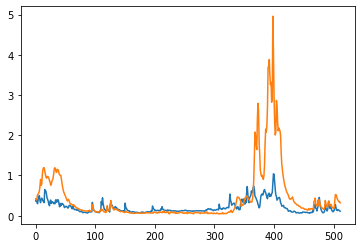

epoch:   0 loss: 68.515619 loss test: 69.739711
243


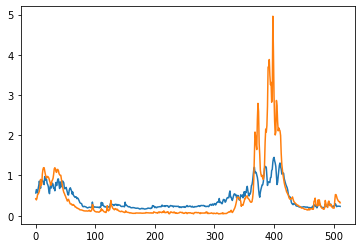

epoch:   1 loss: 0.580650 loss test: 1.797651
202


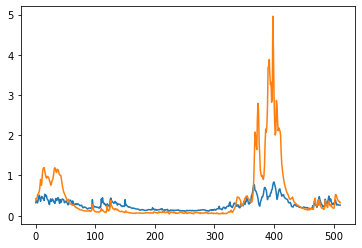

epoch:   2 loss: 0.723725 loss test: 1.440899
171


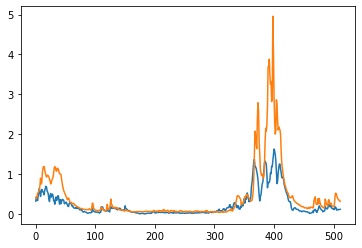

epoch:   3 loss: 0.522424 loss test: 1.427194
150


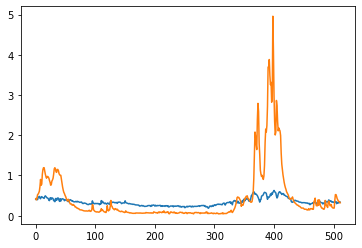

epoch:   4 loss: 0.820504 loss test: 1.748556
138


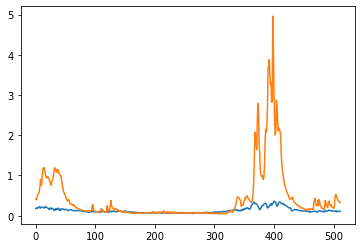

epoch:   5 loss: 0.562646 loss test: 1.740089
129


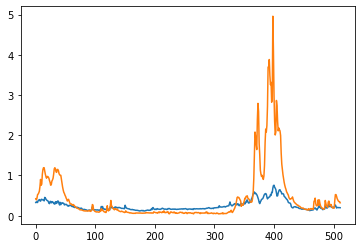

epoch:   6 loss: 0.402269 loss test: 1.868003
121


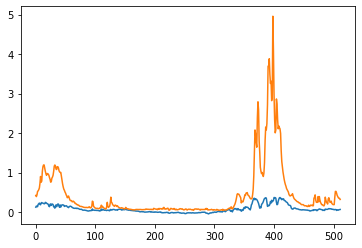

epoch:   7 loss: 0.381406 loss test: 1.714626
117


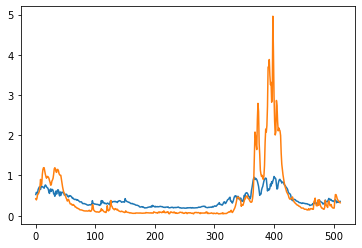

epoch:   8 loss: 0.458455 loss test: 2.097083
113


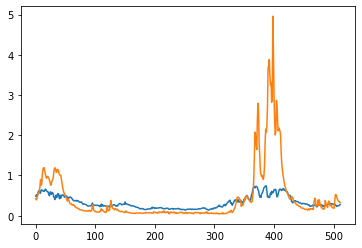

epoch:   9 loss: 0.351316 loss test: 1.471093
110


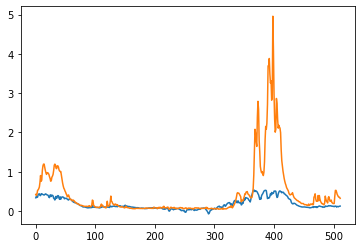

epoch:  10 loss: 0.387421 loss test: 1.542931
106


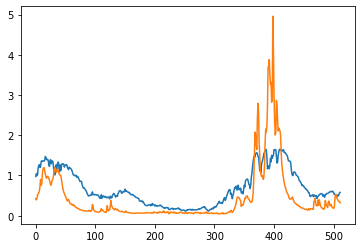

epoch:  11 loss: 0.356056 loss test: 1.709790
105


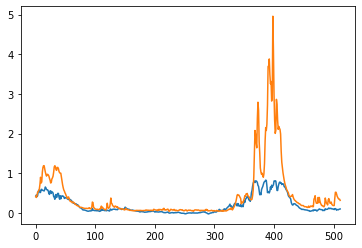

epoch:  12 loss: 1.887855 loss test: 2.411426
98


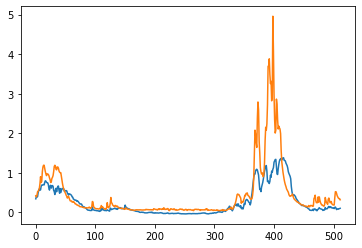

epoch:  13 loss: 0.280164 loss test: 1.256372
94


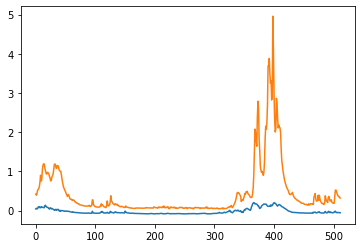

epoch:  14 loss: 0.330483 loss test: 1.161332
90


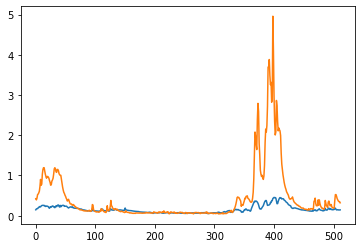

epoch:  15 loss: 0.828968 loss test: 2.801636
88


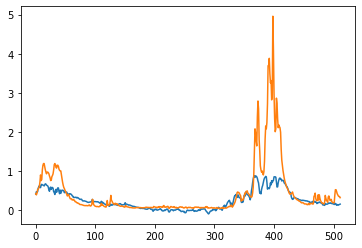

epoch:  16 loss: 0.393508 loss test: 2.021519
88


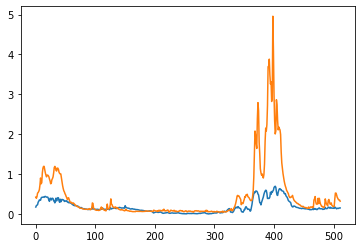

epoch:  17 loss: 0.285239 loss test: 1.334191
87


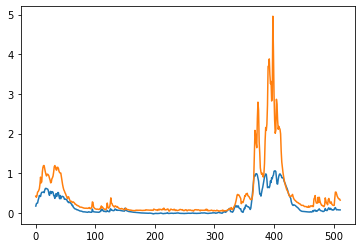

1.4104899791465408
epoch:  18 loss: 0.260386 loss test: 1.410490
85


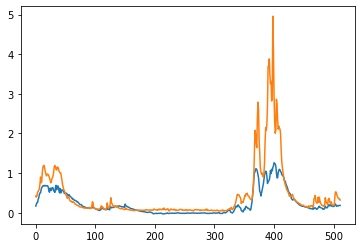

epoch:  19 loss: 0.219477 loss test: 1.249107
85


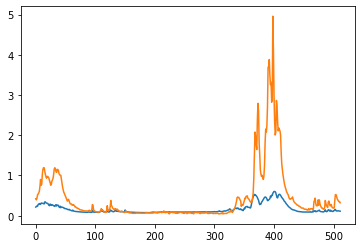

epoch:  20 loss: 0.182066 loss test: 1.014319
83


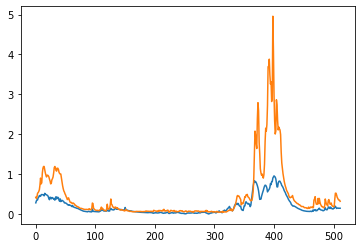

epoch:  21 loss: 0.293329 loss test: 1.669457
83


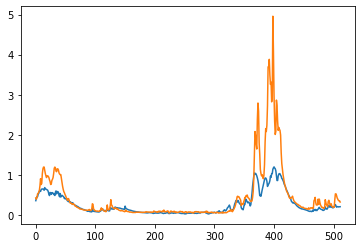

epoch:  22 loss: 0.211907 loss test: 1.391584
83


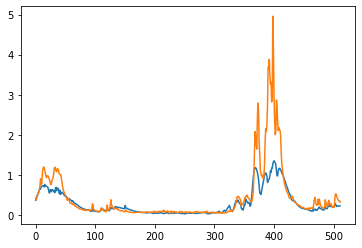

epoch:  23 loss: 0.161184 loss test: 1.109567
83


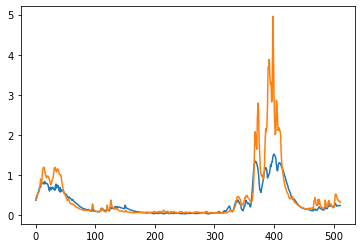

epoch:  24 loss: 0.146231 loss test: 0.972089
83


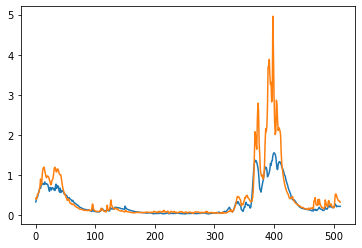

epoch:  25 loss: 0.135945 loss test: 0.876068
83


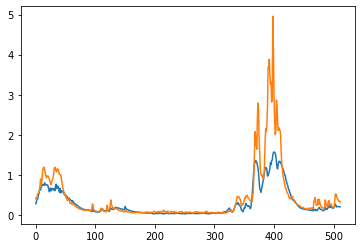

epoch:  26 loss: 0.122797 loss test: 0.843208
83


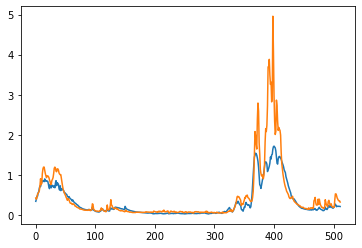

epoch:  27 loss: 0.111402 loss test: 0.862512
83


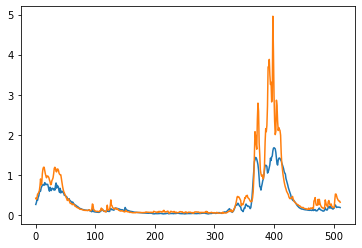

epoch:  28 loss: 0.112701 loss test: 0.757865
83


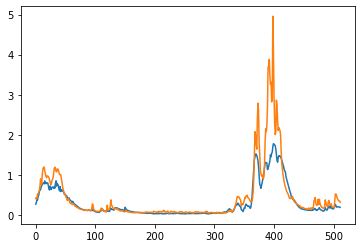

epoch:  29 loss: 0.096231 loss test: 0.792031


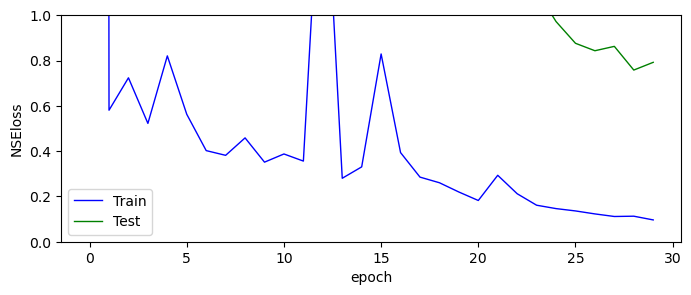

In [50]:
train(main_basin)
# torch.save(seq2seqmodel.state_dict(), 'learntoshare.pt')

In [26]:
testloader_list = []


def TEST_data(time_step, is_train=False, is_valid=False):
    datalist =[]
    std1 = []
    XX = []
    YY = []
    Xs = []

    forcing, area = load_forcing(p, basin_list[main_basin], is_train, is_valid)
    X = forcing
    Y = load_discharge(p, basin_list[main_basin], area, is_train, is_valid)

    X = np.delete(X, np.argwhere(Y < 0)[:, 0], axis=0)
    Y = np.delete(Y, np.argwhere(Y < 0)[:, 0], axis=0)
    if np.sum(np.isnan(Y)) > 0:
        X = np.delete(X, np.argwhere(np.isnan(Y)), axis=0)
        Y = np.delete(Y, np.argwhere(np.isnan(Y)), axis=0)

    X = np.array(create_X(X, time_step))
    Y = np.array(create_Y(Y, time_step))

    dataset = timeseries(X, Y)

    train_loader = DataLoader(dataset, batch_size=256, shuffle=False, drop_last=True)
    datalist.append(train_loader)


    return datalist

In [27]:
testloader_list = TEST_data(270)

In [56]:
model = seq2seq(hidden_size, in_size,  num_layer, future_step, 0.4,device).to(device)
m_state_dict = torch.load('30epoch.pt')
model.load_state_dict(m_state_dict)
model.eval()

/root/miniconda3/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


seq2seq(
  (dropout): Dropout(p=0.4, inplace=False)
  (encoder_lstm): LSTM(32, 256, batch_first=True, dropout=0.4)
  (decoder_lstm): LSTM(256, 256, batch_first=True, dropout=0.4)
  (out): Linear(in_features=512, out_features=1, bias=True)
)

In [57]:
def get_predict():

    all_predicts = []
    all_observation = []

    Xs = load_attribute_232(basin_list[main_basin])
    Xs = torch.tensor(Xs, dtype=torch.float32).unsqueeze(0).to(device)
    predicts = list()
    observation = list()
    for X, Y in testloader_list[0]:

        X = X.to(device)
        predict = model(X, Xs)
        predict[predict < 0] = 0    
        true = Y.cpu().detach().numpy()
        predicts.append(predict.cpu().detach().numpy())
        observation.append(true)

    all_predicts += [predicts]
    all_observation += [observation]


    return  np.array(all_predicts), np.array(all_observation)

In [58]:
predict,true = get_predict()

In [59]:
def NSE(true, fore):
    true = true.reshape(-1)
    fore = fore.reshape(-1)
    x = []
    for i in range(len(fore)):
        x.append(i)
    fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    plt.plot(x, fore, label='predict')
    plt.plot(x, true, label='true')
    plt.legend()
    plt.show()
    return 1 - np.sum((fore - true) ** 2) / np.sum((true - np.average(true)) ** 2)

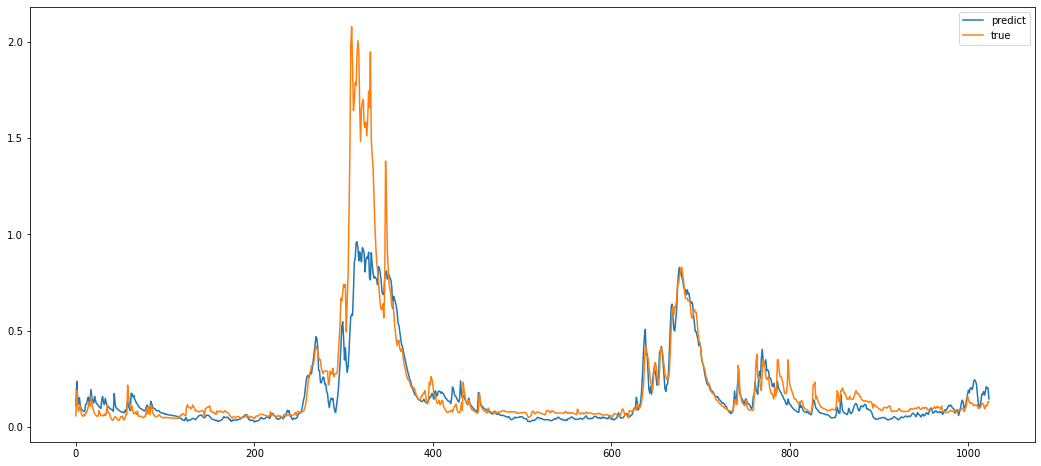

0.7104513645172119


In [60]:
a= predict.reshape(-1)
b = true.reshape(-1)
nse = NSE(b[b>=0],a[b>=0])
print(nse)